In [7]:
from scipy.io import loadmat
import numpy as np
import utilities_figures as ufig
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [82]:
patient_id = 'ID07'
h_string = '31to39h'
h_offset = 31  # hours
h_range = 9
vmax = 40
ax1_ylim = (0, 150)
ax2_ylim = (0.032, 0.043)
ax3_ylim = None
ax4_ylim = (0.001, 0.003)

In [89]:
patient_id = 'ID08'
h_string = '57to65h'
h_offset = 57  # hours
h_range = 9
vmax = 800
ax1_ylim = None
ax2_ylim = None
ax3_ylim = None
ax4_ylim = (0.001, 0.0025)

In [94]:
patient_id = 'ID11'
h_string = '59to65h'
h_offset = 59  # hours
h_range = 7
vmax = 300
ax1_ylim = None
ax2_ylim = None
ax3_ylim = (0.3, 0.43)
ax4_ylim = (0.0002, 0.0013)

In [99]:
patient_id = 'ID11'
h_string = '129to137h'
h_offset = 129  # hours
h_range = 9
vmax = 300
ax1_ylim = (0, 2000)
ax2_ylim = None
ax3_ylim = (0.29, 0.46)
ax4_ylim = (0, 0.002)

In [100]:
# Parameters
channel_idx = 0
sw_band = (0.5, 4)
nperseg = int(20*fs)
noverlap = int(10*fs)
# t_stamps = [67, 256, 442]   # minutes

data_mat = loadmat('../data/' + patient_id + '_' + h_string + '.mat')
info = loadmat('../data/' + patient_id + '_info.mat')
fs = float(info['fs'])
data_np = data_mat['EEG']
data_list = [data_np[i, :] for i in range(data_np.shape[0])]

In [101]:
data = data_list[channel_idx]

# Get spectral density
f, t, Sxx = signal.spectrogram(data, fs, nperseg=nperseg, noverlap=noverlap, scaling='density')

# Extract slow wave band with tukey window
Sxx_band = Sxx[int(sw_band[0] * Sxx.shape[0] / f[-1]):int(sw_band[1] * Sxx.shape[0] / f[-1]), :]
tukey_window_band = np.tile(signal.tukey(Sxx_band.shape[0]), (Sxx_band.shape[1], 1)).T
Sxx_band_tukey = np.multiply(Sxx_band,  tukey_window_band)

# Compute average band power
swa = np.mean(Sxx_band_tukey, axis=0)

In [102]:
corrmean = np.load('../data/corrmean_' + patient_id + '_' + h_string + '_all.npy')

pre = 'allpos'

ids = []
for h_ in range(h_range):
    for m in range(30):
        h = h_ + h_offset
        m = 2 * m

        zero = ''
        if m < 10:
            zero = '0'

        t_string = str(h) + 'h' + zero + str(m) + 'm'
        if patient_id == 'ID11':
            if h_offset == 59:
                additional = 'a'
            else:
                additional = 'b'
        else:
            additional = ''
        ids.append(pre + '_' + patient_id + additional + '_' + t_string)
        
mean_abs, mse, mae, corr = ufig.mean_weights(ids)
t_results = np.linspace(h_offset, h_offset + h_range, len(mean_abs))


C:\Users\janse\Anaconda3\shy\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


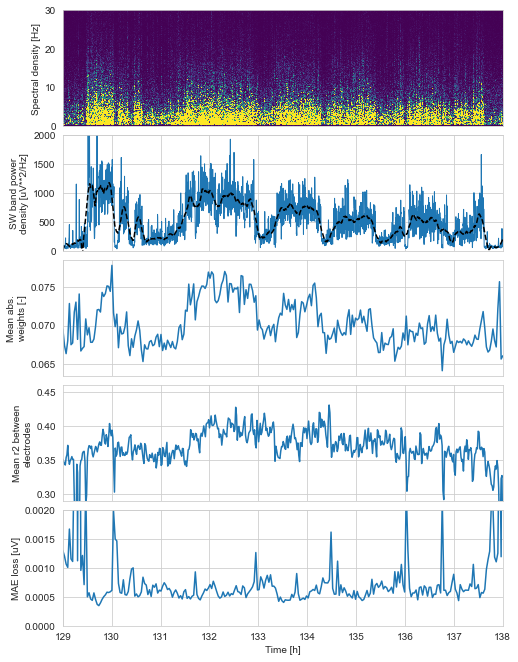

In [103]:
n_subplots = 5
    
fig = plt.figure(figsize=(7, 9))
sns.set_style('whitegrid')
t_hours = t/60/60 + h_offset

ax0 = fig.add_subplot(n_subplots, 1, 1)
plt.pcolormesh(t_hours, f, Sxx, vmax=vmax, cmap='viridis')
ax0.set_ylim(0, 30)
ax0.set_xlim(t_hours[0], t_hours[-1])
ax0.set_ylabel('Spectral density [Hz]')
# ax0.set_xlabel('Time [h]')

ax1 = fig.add_subplot(n_subplots, 1, 2)
plt.plot(t_hours, swa, lw=1)
# for i, t_stamp in enumerate(t_stamps):
#     plt.plot([t_stamp/60 + h_offset, t_stamp/60 + h_offset], [0, upper_ylim], c=sns.color_palette()[i + 1], lw=4)
smooth = signal.savgol_filter(swa, window_length=101, polyorder=3)
plt.plot(t_hours, smooth, c='black', ls='--')
ax1.set_xlim(t_hours[0], t_hours[-1])
if ax1_ylim is not None:
    ax1.set_ylim(ax1_ylim)
ax1.set_ylabel('SW band power\ndensity [uV**2/Hz]')
# ax1.set_xlabel('Time [h]')

ax2 = fig.add_subplot(n_subplots, 1, 3)
plt.plot(t_results, mean_abs)
ax2.set_xlim(t_results[0], t_results[-1])
if ax2_ylim is not None:
    ax2.set_ylim(ax2_ylim)
ax2.set_ylabel('Mean abs.\nweights [-]')
# ax2.set_xlabel('Time [h]')

ax3 = fig.add_subplot(n_subplots, 1, 4)
t_corr = np.linspace(t_hours[0], t_hours[-1], len(corrmean))
upper_ylim = np.max(corrmean)+np.max(corrmean)/10
lower_ylim = np.min(corrmean)-np.min(corrmean)/10
plt.plot(t_corr, corrmean)
# for i, t_stamp in enumerate(t_stamps):
#     plt.plot([t_stamp/60 + h_offset, t_stamp/60 + h_offset], [lower_ylim, upper_ylim], c=sns.color_palette()[i + 1], lw=4)
ax3.set_xlim(t_hours[0], t_hours[-1])
if ax3_ylim is not None:
    ax3.set_ylim(ax3_ylim)
else:
    ax3.set_ylim(lower_ylim, upper_ylim)
ax3.set_ylabel('Mean r2 between\nelectrodes')
# ax3.set_xlabel('Time [h]')

ax4 = fig.add_subplot(n_subplots, 1, 5)
plt.plot(t_results, mae)
ax4.set_xlim(t_results[0], t_results[-1])
if ax4_ylim is not None:
    ax4.set_ylim(ax4_ylim)
ax4.set_ylabel('MAE loss [uV]')
ax4.set_xlabel('Time [h]')

plt.setp(ax0.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)

plt.tight_layout(pad=0)
plt.savefig('timestamps_' + patient_id + '_' + h_string + '.png')
plt.show()

<Figure size 432x288 with 0 Axes>

In [32]:
t_stamps = [67, 256, 442]
for i, val in enumerate(t_stamps):
    val_hour = h_offset+(val/60)
    val_min = (val_hour - np.floor(val_hour)) * 60
    print(str(i) + ' hour: ' + str(np.floor(val_hour)) + ' | min: ' + str(val_min))

0 hour: 32.0 | min: 7.000000000000028
1 hour: 35.0 | min: 15.999999999999943
2 hour: 38.0 | min: 22.00000000000003


In [14]:
corrmat = np.load('../data/corrmat_ID' + ID + '_' + h + '_all.npy')

0.070000000002
0.15
0.22000000000199998


In [26]:
0.1 * (0.1 ** (4 // 2))

0.0010000000000000002

In [18]:
1/6

0.16666666666666666